In [1]:
import os
import urllib 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np



DOWNLOAD_PATH = "https://raw.githubusercontent.com/JesusNoelValMo/Machine_Learning_Book/master/Chapter_3_Classification/Chapter_3_Exercise_3/train.csv"


In [2]:
def load_dataset(DOWNLOAD_PATH):
  return pd.read_csv(DOWNLOAD_PATH)
  

In [3]:
data = load_dataset(DOWNLOAD_PATH)
labels = data["Survived"]
features = data.drop(columns='Survived')
features


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Age            1.000000
Fare           0.096067
PassengerId    0.036847
Parch         -0.189119
SibSp         -0.308247
Pclass        -0.369226
Name: Age, dtype: float64


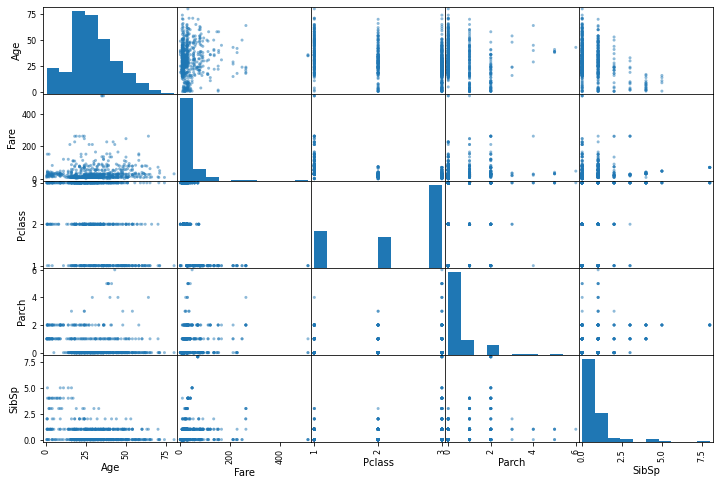

In [4]:
corr_matrix = features.corr()
attributes = ["Age", "Fare", "Pclass", "Parch", "SibSp"]
scatter_matrix(features[attributes], figsize=(12,8))
print(corr_matrix["Age"].sort_values(ascending=False))

In [5]:
#clean our features, let's drop unnecesary data
features = features.drop(columns=["Name", "Ticket", "PassengerId"])


In [6]:
features


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,NaN,S
887,1,female,19.0,0,0,30.0000,B42,S
888,3,female,NaN,1,2,23.4500,NaN,S
889,1,male,26.0,0,0,30.0000,C148,C


In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [8]:
#Let's take care about the missing data
#FOR AGE
from sklearn.impute import SimpleImputer
#We will fill our missing data with the mean values
imputer = SimpleImputer(strategy="mean")


#Take only de attributes that we need
features_num = features.drop(columns=["Cabin", "Embarked", "Sex"])
#the double square bracket is for assugn an array of features
features_no_num = features[["Cabin", "Embarked", "Sex"]]

imputer.fit(features_num)
imputer.statistics_
X = imputer.transform(features_num)
features_num_filled = pd.DataFrame(X, columns=features_num.columns, index=features_num.index)
features_num_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    float64
 1   Age     891 non-null    float64
 2   SibSp   891 non-null    float64
 3   Parch   891 non-null    float64
 4   Fare    891 non-null    float64
dtypes: float64(5)
memory usage: 34.9 KB


In [9]:
#Let's one hot encode the sex attribute
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding_function(feature):
  feature_encoder = OneHotEncoder()
  feature_encoded = feature_encoder.fit_transform(feature)
  return feature_encoded.toarray()


In [10]:
  #Let's transform all of our non numerical data
sex_attrib_one_hot_encoded = one_hot_encoding_function(features_no_num[["Sex"]])

#our embarked feature contains null values, so, let's fix this issue
#because of there is only 3 null values it is ok if we fill it with any value
#Lets create a transformer
Embarked_feature = features_no_num[["Embarked"]]

from sklearn.base import BaseEstimator, TransformerMixin 
class fill_embarked_feature(BaseEstimator, TransformerMixin):
    def fit(self, Embarked_feature, y=None):
      return self

    def transform(self, Embarked_feature):
      emb = Embarked_feature.fillna("No Embarked")
      
      return emb     
filler = fill_embarked_feature()
embarked_filled = filler.transform(Embarked_feature)
embarked_filled


,Embarked
0,S
1,C
2,S
3,S
4,S
...,...
886,S
887,S
888,S
889,C


In [11]:
#Once our embarked attribute were one hot encoded, we only have to take care about 
#the cabin number
Embarked_encoder = OneHotEncoder()
embarked_encoded = Embarked_encoder.fit_transform(embarked_filled)
embarked_encoded.toarray()

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [12]:
#Taking care of cabin number 
#we only want to know if the passanger's cabin was specyfied or not
#We need to build a custom transformer that, if the value is null, we replace it with a False
#if the cabin is specyfied, the value will be replaced with a 1
class cabin_specyfied_transformer(BaseEstimator, TransformerMixin):
  def fit(self, Cabin_attribute):
    return self

  def transform(self, Cabin_attribute, y=None):
   

    result = (pd.notnull(Cabin_attribute))

    return result

    
    



  

In [13]:
Cabin_attrib = features_no_num[["Cabin"]]
Cabin_attrib_transformer =  cabin_specyfied_transformer()
Cabin_attrib_transformed = Cabin_attrib_transformer.fit_transform(Cabin_attrib)


In [14]:
#Let's one hot encode this attribute as well
Cabin_encoder = OneHotEncoder()
Cabin_attrib_transformed_1Hot = Cabin_encoder.fit_transform(Cabin_attrib_transformed)
Cabin_attrib_transformed_1Hot.toarray()


array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [15]:
#Let's Create a pipeline in order to do all of our transformations
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
   ('imputer' , SimpleImputer(strategy="mean"))
])

num_attribs = list(features_num)

embarked_att = ["Embarked"]
embark_transformer = Pipeline([
  ('fill', fill_embarked_feature()), 
  ("onehot", OneHotEncoder())
])

cabin_att = ["Cabin"]
cabin_transformer = Pipeline([
  ('Iscabinspecyfied', cabin_specyfied_transformer()), 
  ('onehot', OneHotEncoder())
])


sex_att = ["Sex"]

from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
                                   
  ('Pclass', num_pipeline, ['Pclass']), 
  ('sex_attrib', OneHotEncoder(), sex_att),
  ('numeric', num_pipeline, ['Age', 'SibSp', 'Parch', 'Fare']), 
  ('cabin_transformer', cabin_transformer, cabin_att),
  ('embark_transformer', embark_transformer, embarked_att),
  

])

In [16]:
data_prepared = full_pipeline.fit_transform(features)
pd.DataFrame(data_prepared,columns=['Pclass', 'female', 'male', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_yes','Cabin_no','Embarked_C','No Embarked','Embarked_Q' ,'Embarked_S'])

,Pclass,female,male,Age,SibSp,Parch,Fare,Cabin_yes,Cabin_no,Embarked_C,No Embarked,Embarked_Q,Embarked_S
0,3.0,0.0,1.0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,38.000000,1.0,0.0,71.2833,0.0,1.0,1.0,0.0,0.0,0.0
2,3.0,1.0,0.0,26.000000,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,1.0
4,3.0,0.0,1.0,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2.0,0.0,1.0,27.000000,0.0,0.0,13.0000,1.0,0.0,0.0,0.0,0.0,1.0
887,1.0,1.0,0.0,19.000000,0.0,0.0,30.0000,0.0,1.0,0.0,0.0,0.0,1.0
888,3.0,1.0,0.0,29.699118,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,0.0,1.0
889,1.0,0.0,1.0,26.000000,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0


In [17]:
#Let's train our models with SGDClassifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(data_prepared, labels)

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

forest_clf.fit(data_prepared, labels)




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
#Let's see how well the model is 
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, data_prepared, labels, cv=50, scoring="accuracy")


array([0.88888889, 0.72222222, 0.72222222, 0.83333333, 0.83333333,
       0.83333333, 0.66666667, 0.83333333, 0.61111111, 0.83333333,
       0.72222222, 0.72222222, 0.83333333, 0.77777778, 0.61111111,
       0.72222222, 0.77777778, 0.83333333, 0.88888889, 0.88888889,
       0.88888889, 0.77777778, 0.88888889, 0.77777778, 0.72222222,
       0.88888889, 0.88888889, 0.88888889, 0.66666667, 0.88888889,
       0.72222222, 0.72222222, 0.83333333, 0.88888889, 0.83333333,
       0.83333333, 0.77777778, 0.55555556, 0.83333333, 0.77777778,
       0.77777778, 0.82352941, 0.88235294, 0.82352941, 0.94117647,
       0.76470588, 0.82352941, 0.82352941, 0.94117647, 0.94117647])

In [19]:
#Now let's try the test set out!
test_set_path = "https://raw.githubusercontent.com/JesusNoelValMo/Machine_Learning_Book/master/Chapter_3_Classification/Chapter_3_Exercise_3/test.csv"
test_set = load_dataset(test_set_path)
test_set.info()
passenger_id = test_set["PassengerId"]  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [20]:
test_set = test_set.drop(columns=["Name", "Ticket", "PassengerId"])
test_set_prepared = full_pipeline.transform(test_set)


In [21]:
test_set_prepared = pd.DataFrame(test_set_prepared, columns=['Pclass', 'female', 'male', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_yes','Cabin_no','Embarked_C','No Embarked','Embarked_Q' ,'Embarked_S'])
test_set_prepared

,Pclass,female,male,Age,SibSp,Parch,Fare,Cabin_yes,Cabin_no,Embarked_C,No Embarked,Embarked_Q,Embarked_S
0,3.0,0.0,1.0,34.500000,0.0,0.0,7.8292,1.0,0.0,0.0,0.0,1.0,0.0
1,3.0,1.0,0.0,47.000000,1.0,0.0,7.0000,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,0.0,1.0,62.000000,0.0,0.0,9.6875,1.0,0.0,0.0,0.0,1.0,0.0
3,3.0,0.0,1.0,27.000000,0.0,0.0,8.6625,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1.0,0.0,22.000000,1.0,1.0,12.2875,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3.0,0.0,1.0,29.699118,0.0,0.0,8.0500,1.0,0.0,0.0,0.0,0.0,1.0
414,1.0,1.0,0.0,39.000000,0.0,0.0,108.9000,0.0,1.0,1.0,0.0,0.0,0.0
415,3.0,0.0,1.0,38.500000,0.0,0.0,7.2500,1.0,0.0,0.0,0.0,0.0,1.0
416,3.0,0.0,1.0,29.699118,0.0,0.0,8.0500,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
predictions = forest_clf.predict(test_set_prepared)

passenger_id 
data_frame_predictions = pd.DataFrame(passenger_id, columns=["PassengerId"])
data_frame_predictions["Survived"] = predictions
data_frame_predictions.set_index("PassengerId", inplace=True)
data_frame_predictions.to_csv('predictions.csv')
data_frame_predictions
from google.colab import files
files.download("predictions.csv")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#Let's Fine tune our model 
from sklearn.model_selection import GridSearchCV
grid_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]
}
gridsearch = GridSearchCV(forest_clf, grid_params,scoring="accuracy", cv= 5, return_train_score=True)



In [27]:
gridsearch.fit(data_prepared, labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [34]:
#Let's save and download our model 
import joblib

final_model = gridsearch.best_estimator_
final_model
#joblib.dump(final_model, "ForestClassifier_titanic.pkl")
#files.download("ForestClassifier_titanic.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
#Calling the model and using it
forest_clf_fine_tunned = joblib.load("ForestClassifier_titanic.pkl")
predictions_fine_tuned = forest_clf_fine_tunned.predict(test_set_prepared)


data_frame_predictions_fine_tuned = pd.DataFrame(passenger_id, columns=["PassengerId"])
data_frame_predictions_fine_tuned["Survived"] = predictions_fine_tuned
data_frame_predictions_fine_tuned.set_index("PassengerId", inplace=True)
data_frame_predictions_fine_tuned.to_csv('predictions_fine_tuned.csv')
#files.download("predictions_fine_tuned.csv")
data_frame_predictions_fine_tuned






,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
